In [1]:
# basic library
import pandas as pd
import numpy as np
import re
import string
import os
# import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# model
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# stop words
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# stememer
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# nltk corpus
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# tokenizer
from transformers import BertTokenizer
from tokenizers import Tokenizer

# vectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# other preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# training pipline
import tensorflow as tf
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# label encoding
label_type = ['NotPromotion', 'Promotion']

c:\Users\tyogo\.conda\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %load_ext cudf.pandas

# %pip install seaborn
# %pip install Sastrawi
# %pip install wordcloud
# %pip install torch
# %pip install transformers
# %pip install nltk
# %pip install tensorflow
# %pip install gensim --upgrade
# %pip install Sastrawi
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [2]:
combined_data = pd.read_csv('../Dataset/dataset_combined_new - dataset_combined_new.csv', sep=',')
training_data = pd.read_csv('../Dataset/train.csv', sep=',').dropna()
testing_data = pd.read_csv('../Dataset/test.csv', sep=',')
validation_data = pd.read_csv('../Dataset/val.csv')

# training_data = training_data.sample(frac = 1)
training_data.head()

,text,label
0,Mencari pengalaman daring yang lancar? AERO88 ...,1
1,Itu kayanya di kasih tanda deh yg bisa di lewa...,0
2,Whatsapp Telegram Livechat Daftar Login Hdtoto...,1
3,KO SELASA SI BABG,0
4,"TERLEPAS DARI GAME NYA YANG BAGUS, SEMOGA BANG...",0


In [3]:
print("train isna:",training_data['text'].isna().sum())
print("test isna:",testing_data['text'].isna().sum())
print("val isna:",validation_data['text'].isna().sum())

print(training_data[training_data['text'].isna()][['text', 'label']])


train isna: 0
test isna: 0
val isna: 0
Empty DataFrame
Columns: [text, label]
Index: []


# Preprocessing

In [4]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
drop_stopwords = ['pula', 'pasti', 'amat', 'ingin', 'sampai']

stopwords += custom_stopwords
stopwords = [word for word in stopwords if word not in drop_stopwords]

pattern = r"[^A-Za-z ]"

print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'seharusnya', 's

In [5]:
def preprocess_text(texts):
    sentences=[]
    for index, text in enumerate(texts):

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]
        
        text = ' '.join(word_list)
        texts[index] = text
        sentences.append(word_list)
    return texts, sentences

In [6]:
texts_raw_train = training_data['text'].values.copy()
texts_raw_val = validation_data['text'].values.copy()
texts_raw_test = testing_data['text'].values.copy()
y_train = training_data['label'].values.copy()
y_val = validation_data['label'].values.copy()
y_test = testing_data['label'].values.copy()

In [7]:
texts_train,sentences = preprocess_text(texts_raw_train)
texts_val,_ = preprocess_text(texts_raw_val)
texts_test,_ = preprocess_text(texts_raw_test)

texts_train

array(['Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .',
       'Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru',
       'Whatsapp Telegram Livechat Daftar Login Hdtoto Beranda Slot Online Live Casino Sportsbook Arcade Togel Poker slider Jackpot Daily Wins Gates of Olympus Bonanza Gold < Starlight Princess Sweet power thor megaways Treasure Wild Aztec Gems Gatot Kaca Popular Games bowl Mahjong Ways Break Away Lucky Wilds Koi Gate 1000 Wishes Gem Saviour Conquest Chronicles X Up Gold Blitz Elven Roma Silverback Multiplier Mountain Fiery Sevens Hot Phoenix Rises Neko Fortune Tiger garuda Treasures Bandito fireworks Dreams Macau Rooster Rumble > Platform Hiburan Terbaru No.1 Indonesia Penyedia pragmatic pgsoft habanero cq9 spadegaming ttg joker microgaming ion sexy gaming allbet idnlive saba sports Metode Pembayaran Transfer Bank Pulsa E-Money ©2024 Hdtoto . All rights reserved | 18+',
       ..., 'Kerennn',
       'Saya merekomendasikan ρ

# Tokenization & Vectorizer

In [9]:
# Define parameters

EMBEDDING_DIM = 300
MAX_LEN = 128

## Torch Tokenization

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_train)

train_texts_seq = tokenizer.texts_to_sequences(texts_train)
val_texts_seq = tokenizer.texts_to_sequences(texts_val)
test_texts_seq = tokenizer.texts_to_sequences(texts_test)

train_texts_padded = pad_sequences(train_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')
val_texts_padded = pad_sequences(val_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')
test_texts_padded = pad_sequences(test_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [11]:
train_texts_padded.shape

(2736, 128)

## Word2Vec Vectorizer 

In [12]:
w2v_model = Word2Vec(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)
embedding_words = list(w2v_model.wv.key_to_index)

In [13]:
w2v_model.wv.most_similar('AERO88')

[('!', 0.9775429964065552),
 (',', 0.9765005707740784),
 ('.', 0.9753140807151794),
 ('game', 0.974048912525177),
 ('Anda', 0.9734162092208862),
 ('bang', 0.9731408357620239),
 (':', 0.9731035232543945),
 ('banget', 0.9727646112442017),
 ('Indonesia', 0.9725455045700073),
 ('banyak', 0.9724539518356323)]

In [16]:
w2v_model.vector_size

300

In [17]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
VOCAB_SIZE

11021

In [23]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM)

In [ ]:
# # Print some statistics first to understand the vocabulary coverage
# vocab_size = len(tokenizer.word_index)
# w2v_vocab_size = len(w2v_model.wv.key_to_index)
# missing_count = 0

# embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
# for word, i in tokenizer.word_index.items():
#     if word in w2v_model.wv:
#         embedding_matrix[i] = w2v_model.wv[word]
#     else:
#         missing_count += 1
#         print(i)
#         # Initialize missing words with random small numbers instead of zeros
#         embedding_matrix[i] = np.random.uniform(-0.25, 0.25, EMBEDDING_DIM)

# print(f"Total words in tokenizer: {vocab_size}")
# print(f"Total words in Word2Vec: {w2v_vocab_size}")
# print(f"Words not found in Word2Vec: {missing_count} ({(missing_count/vocab_size*100):.2f}%)")

8
22
49
71
94
103
107
109
116
124
131
148
154
155
156
170
196
198
202
206
207
232
235
236
239
241
259
288
300
313
318
320
333
344
346
354
359
365
375
386
388
394
396
398
413
417
432
433
438
440
446
453
457
475
480
489
490
495
513
531
533
565
568
576
580
586
590
596
603
610
613
617
620
623
626
628
634
636
640
651
656
663
664
666
668
674
676
679
689
692
699
704
713
714
716
719
722
726
727
734
737
744
748
755
769
772
777
788
798
805
806
809
816
824
830
835
847
878
888
890
892
893
899
913
914
936
943
951
955
968
969
970
971
972
976
980
981
983
985
986
990
991
999
1012
1015
1025
1032
1036
1037
1043
1046
1049
1050
1076
1077
1078
1079
1080
1082
1083
1084
1085
1087
1094
1108
1109
1111
1112
1113
1114
1118
1120
1121
1124
1129
1141
1144
1145
1146
1168
1169
1171
1172
1174
1181
1183
1184
1185
1186
1187
1203
1204
1214
1216
1217
1218
1219
1221
1222
1236
1240
1251
1253
1255
1258
1261
1266
1267
1268
1269
1273
1287
1291
1298
1302
1304
1305
1306
1307
1311
1315
1325
1329
1330
1336
1339
1341
1344
1345
1350

# Training

In [24]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

drop_value = 0.2
# n_dense = 24
print("vocab size:", VOCAB_SIZE)

vocab size: 11021


In [25]:
model = Sequential()

model.add(Embedding(
    input_dim=VOCAB_SIZE, 
    output_dim=EMBEDDING_DIM, 
    weights=[embedding_matrix], 
    trainable=True
    ))
# model.add(GlobalAveragePooling1D())
model.add(SpatialDropout1D(drop_value))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.3))

# model.add(GlobalAveragePooling1D())
model.add(Flatten())

# Fully connected layers
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,306,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,300 (12.61 MB)

 Trainable params: 3,306,300 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

None


In [26]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.685027541311968, 1: 1.851150202976996}

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

checkpoint_callback = ModelCheckpoint(filepath='best_model_checkpoint.keras',  
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=False,  # Save full model (architecture + weights)
                                      verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

num_epochs = 100
history = model.fit(
    train_texts_padded,
    y_train,
    validation_data=(val_texts_padded,y_val),
    epochs=num_epochs,
    callbacks=[checkpoint_callback],
    class_weight=class_weights
)


Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6094 - loss: 1.2237
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to best_model_checkpoint.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.6095 - loss: 1.2235 - val_accuracy: 0.7143 - val_loss: 1.1725
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6070 - loss: 1.1608
Epoch 2: val_accuracy improved from 0.71429 to 0.77259, saving model to best_model_checkpoint.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.6071 - loss: 1.1605 - val_accuracy: 0.7726 - val_loss: 1.0975
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7237 - loss: 1.0880
Epoch 3: val_accuracy improved from 0.77259 to 0.79883, saving model to best_model_checkpoint.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.7239 - loss: 1.0877 - val_accuracy: 0.7988 - val_loss: 0.9886
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7815 - loss: 0.9692
Epoch 4: v

In [35]:
from tensorflow.keras.models import load_model
model = load_model("best_model_checkpoint.keras")

model.save("../Model/LSTM_WORD2VEC_TORCH_EMBEDDING_TRAINABLETRUE_ZERO.h5")
model.save("../Model/LSTM_WORD2VEC_TORCH_EMBEDDING_TRAINABLETRUE_ZERO.keras")

# Eval

In [14]:
from tensorflow.keras.models import load_model

model = load_model("../Model/LSTM_WORD2VEC_TORCH_EMBEDDING_TRAINABLETRUE_ZERO.keras")

c:\Users\tyogo\.conda\envs\nlp\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
model.evaluate(test_texts_padded, y_test, verbose=0)


[0.18788887560367584, 0.9736841917037964]

In [31]:
best_epoch = np.argmin(history.history['val_loss']) + 1
best_epoch

38

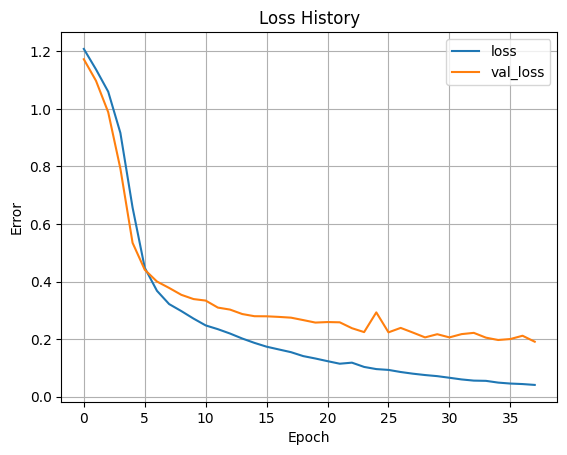

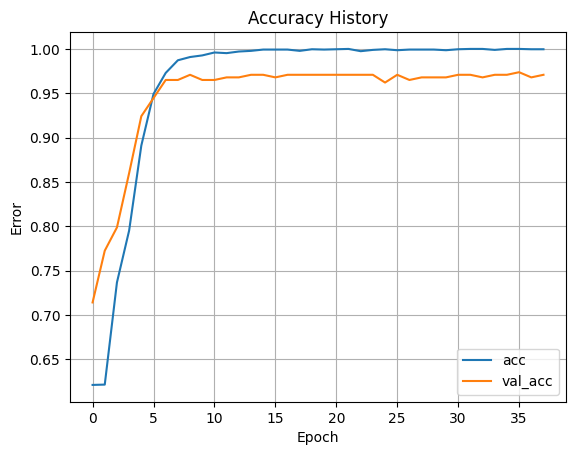

In [34]:
plt.plot(history.history['loss'][:best_epoch], label='loss')
plt.plot(history.history['val_loss'][:best_epoch], label='val_loss')
# plt.ylim([0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.title("Loss History")
plt.show()

plt.plot(history.history['accuracy'][:best_epoch], label='acc')
plt.plot(history.history['val_accuracy'][:best_epoch], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title("Accuracy History")
plt.grid(True)

In [24]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import average_precision_score

y_probs = model.predict(test_texts_padded)
y_probs = y_probs.flatten()

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {f1s[best_idx]:.4f}")

ap_score = average_precision_score(y_test, y_probs)
print(f"Average Precision (AP) Score: {ap_score:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Best Threshold: 0.9878
Best F1-Score: 0.9613
Average Precision (AP) Score: 0.9906


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy Score: 0.97953216374269
F1 Score: 0.9613259668508287
Recall Score: 0.9775280898876404
Precision Score: 0.9456521739130435
Classification Report: 
              precision    recall  f1-score   support

NotPromotion       0.98      0.99      0.99       250
   Promotion       0.98      0.95      0.96        92

    accuracy                           0.98       342
   macro avg       0.98      0.97      0.97       342
weighted avg       0.98      0.98      0.98       342

Confusion Matrix:



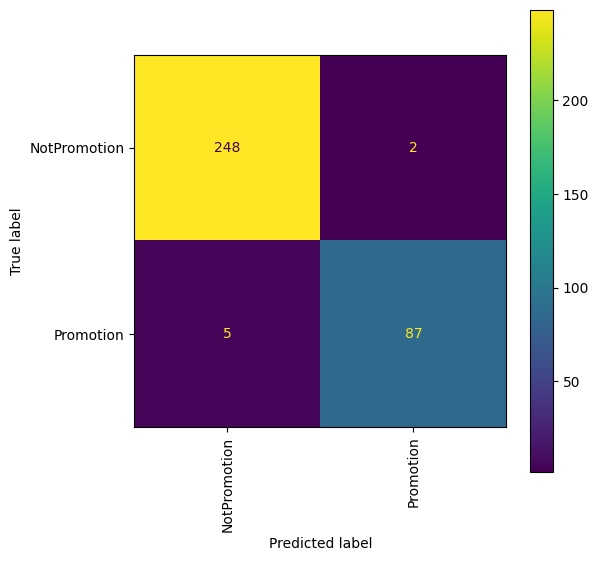

In [25]:
pred = model.predict(test_texts_padded)
y_pred = [0 if pred < best_threshold else 1 for pred in pred]

print(f"Accuracy Score: {accuracy_score(y_pred, y_test)}")
print(f"F1 Score: {f1_score(y_pred, y_test)}")
print(f"Recall Score: {recall_score(y_pred, y_test)}")
print(f"Precision Score: {precision_score(y_pred, y_test)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred, target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(6,6))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')
plt.show()

In [19]:
for idx,i in enumerate(y_pred):
    if i != y_test[idx]:
        print(idx+1,")❌pred:", i, "| label:", y_test[idx], texts_test[idx])
        continue
    print(idx+1,") pred:", i, "| label:", y_test[idx], texts_test[idx])

1 ) pred: 1 | label: 1 INFO CINA777APK CINA777RTP CINA777Logo24/11/2024 ( Min ) 14.56 ( GMT+07 ) Versi MobileVersi WAP ( NEX4D ) Nama PenggunaKata SandiLupa Kata Sandi ? DaftarHomeTogelHot GamesSlotsLive CasinoOlahragaCrash GameArcadePokerE-SportsSabung AyamPromosiWelcome to situs resmi CINA777 | Kami membayar berapapun kemenangan player.HasilPasaranBuku MimpiHasil TerakhirStatistik MarketGame PopulerMahjong Wins 3 – Black ScatterMAINMahjong Wins 3 – Black ScatterMahjong WaysMAINMahjong WaysMighty HerculesMAINMighty HerculesSlot88 BonanzaMAINSlot88 BonanzaLe PharaohMAINLe PharaohPirate Quest 1000MAINPirate Quest 1000SixSixSixMAINSixSixSixWay of NinjaMAINWay of Ninja888 GoldMAIN888 GoldMahjong Ways 2MAINMahjong Ways 2Gates of Olympus 1000™MAINGates of Olympus 1000™Wild Bounty ShowdownMAINWild Bounty ShowdownLucky Twins NexusMAINLucky Twins NexusNexus Koi GateMAINNexus Koi GateThe CryptMAINThe CryptLucky Twins Power ClustersMAINLucky Twins Power ClustersMentalMAINMentalFortune Gems 2MAIN

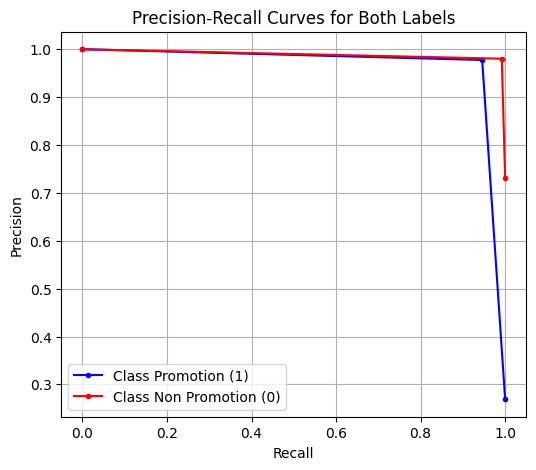

In [18]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision-recall values for class 1 (positive class)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred)

# Compute precision-recall values for class 0 (negative class)
y_scores_neg = 1 - np.array(y_pred)  # Since model predicts class 1 probabilities, class 0 is (1 - probability)
precision_0, recall_0, _ = precision_recall_curve(1 - y_test, y_scores_neg)

# Plot Precision-Recall curves for both classes
plt.figure(figsize=(6, 5))
plt.plot(recall_1, precision_1, marker='.', label=f'Class Promotion (1)', color='blue')
plt.plot(recall_0, precision_0, marker='.', label=f'Class Non Promotion (0)', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Both Labels')
plt.legend()
plt.grid()
plt.show()

In [26]:
def predict_sentiment(text):
    use_text,_ = preprocess_text(text)
    # inputs = tokenizer(use_text, padding=True, truncation=True, return_tensors='tf', max_length=512)
    use_text = tokenizer.texts_to_sequences(use_text)
    use_text = pad_sequences(use_text, maxlen=MAX_LEN, padding='post', truncating='post')

    pred = model.predict(use_text)
    # pred_labels = tf.argmax(pred, axis=1)
    pred_labels = [0 if pred < best_threshold else 1 for pred in pred]
    # print(pred)
 
    pred_labels = [label_type[label] for label in pred_labels]
    for index, preds in enumerate(pred_labels):
        print(f"{text[index]}: {preds}")
text = [
    "Aku adalah seorang mahasiswa",
    "Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov",
    "Gacor xxtoto menang pasti dibayar",
    "dp jd jt buruan gas garansi meteorwin",
    "gacor pasti menang di xxtoto",
    "top up di kantorbola pasti gampang menangnya",
    "gratis koin buruan topup di agencasinoindonesia",
    "gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda",
    "DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣",
    "DEWA-DORA tuh situs    yang paling gampang narik tiap hari! 😖 😣",
    "Gua setia maen di DEWADORA, tempat terbaik!",
    "kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar.",
    "dapatkan banyak rejekii di DEWADORА!"
]
predict_sentiment(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Aku seorang mahasiswa: NotPromotion
Judi Online Disebut Masuk Tahap Sosial , Cak Imin : 8,8 Juta Pasien Minta Direhabilitasi Jumat , 15 Nov: NotPromotion
Gacor xxtoto menang pasti dibayar: Promotion
dp jd jt buruan gas garansi meteorwin: NotPromotion
gacor pasti menang xxtoto: Promotion
top up kantorbola pasti gampang menangnya: NotPromotion
gratis koin buruan topup agencasinoindonesia: NotPromotion
gratis koin buruan topup fairbet88.com , segera daftarkan akun: NotPromotion
DEWA-DORA tuh situs paling enak withdraw tiap hari ! 😖 😣: Promotion
DEWA-DORA tuh situs paling gampang narik tiap hari ! 😖 😣: Promotion
Gua setia maen DEWADORA , tempat terbaik !: Promotion
kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung Menang berapapun dibayar .: Promotion
dapatkan banyak rejekii DEWADORА !: Promotion
